<img src="https://raw.github.com/emsig/logos/main/empymod/empymod-logo.png" width="400" alt="Logo empymod" title="Logo empymod">
    

### Full 3D electromagnetic modeller for 1D VTI media


The modeller empymod can compute electric or magnetic responses due to a 3D electric or magnetic source in a layered-earth model with vertical transverse isotropic (VTI) resistivity, VTI electric permittivity, and VTI magnetic permeability, from very low frequencies (DC) to very high frequencies (GPR). The computation is carried out in the wavenumber-frequency domain, and various Hankel- and Fourier-transform methods are included to transform the responses into the space-frequency and space-time domains.

- Manual: https://empymod.emsig.xyz
- Gallery: https://empymod.emsig.xyz/en/stable/gallery
- Code: https://github.com/emsig/empymod
- Installation: https://empymod.emsig.xyz/en/stable/manual/installation.html


## Topics

- EM Green's functions at its core
- Analytic in the wavenumber-frequency domain
- Brief look at the Manual, API & Gallery
- Start with simple example
- Dipole
- Bipole
- Loop
- IP
- CLI



## Minimal example using only empymod

In [1]:
import empymod

In [2]:
# Check the report - can be useful
empymod.Report()

--------------------------------------------------------------------------------
  Date: Sat Feb 11 20:02:21 2023 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:20:04) [GCC
  11.3.0]

             numpy : 1.23.5
             scipy : 1.10.0
             numba : 0.56.4
           empymod : 2.2.1
           IPython : 8.9.0
        matplotlib : 3.6.3
--------------------------------------------------------------------------------

In [3]:
# Look at docs
empymod.dipole?

Signature:
empymod.dipole(
    src,
    rec,
    depth,
    res,
    freqtime,
    signal=None,
    ab=11,
    aniso=None,
    epermH=None,
    epermV=None,
    mpermH=None,
    mpermV=None,
    **kwargs,
)
Docstring:
Return EM fields due to infinitesimal small EM dipoles.

Calculate the electromagnetic frequency- or time-domain field due to
infinitesimal small electric or magnetic dipole source(s), measured by
infinitesimal small electric or magnetic dipole receiver(s); sources and
receivers are directed along the principal directions x, y, or z, and all
sources are at the same depth, as well as all receivers are at the same
depth.

Use the functions :func:`bipole` to calculate dipoles with arbitrary angles
or bipoles of finite length and arbitrary angle.

The function :func:`dipole` could be replaced by :func:`bipole` (all there
is to do is translate `ab` into `msrc`, `mrec`, `azimuth`'s and `dip`'s).
However, :func:`dipole` is kept separately to serve as an example of a
simple model

In [4]:
empymod.dipole(
    src=(0, 0, -250),
    rec=(1000, 0, -300),
    depth=[0, -300, -1000, -1100],
    res=[2e14, 0.3, 1, 100, 1],
    freqtime=1,
    ##ab=55,
    ##verb=1,
)


:: empymod END; runtime = 0:00:00.289336 :: 1 kernel call(s)



EMArray(-8.09007211e-12-3.66256174e-11j)

## Basic example with numpy and matplotlib
A simple frequency-domain example, where we keep most of the parameters left at the default value:

In [5]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

First we define the survey parameters: source and receiver locations, and source frequencies.

In [6]:
# x-directed bipole source: x0, x1, y0, y1, z0, z1
source = [-50, 50, 0, 0, -100, -100]

# Source frequency
frequency1 = 1

# Receiver offsets
offsets1 = np.linspace(500, 5000, 301)

# x-directed dipole receiver-array: x, y, z, azimuth, dip
receivers1 = [offsets1, offsets1*0, -200, 0, 0]

Next, we define the resistivity model:

In [7]:
# Layer boundaries
depth = [0, -300, -1000, -1050]

# Layer resistivities
resistivities = [2e14, 0.3, 1, 50, 1]

And finally we compute the electromagnetic response at receiver locations:

In [8]:
efield1 = empymod.bipole(
    src=source,
    rec=receivers1,
    depth=depth,
    res=resistivities,
    freqtime=frequency1,
    htarg={'pts_per_dec': -1},
    verb=2,
)


:: empymod END; runtime = 0:00:00.005847 :: 1 kernel call(s)



Let’s plot the resulting responses:

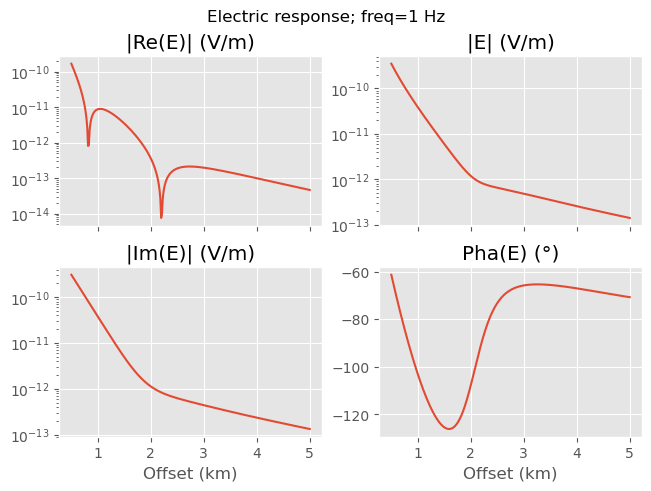

In [9]:
fig1, ((ax11, ax12), (ax13, ax14)) = plt.subplots(2, 2, sharex=True, constrained_layout=True)

fig1.suptitle(f'Electric response; freq={frequency1} Hz')

ax11.set_title('|Re(E)| (V/m)')
ax11.semilogy(offsets1/1e3, abs(efield1.real))

ax12.set_title('|E| (V/m)')
ax12.semilogy(offsets1/1e3, efield1.amp())

ax13.set_title('|Im(E)| (V/m)')
ax13.semilogy(offsets1/1e3, abs(efield1.imag))

ax14.set_title('Pha(E) (°)')
ax14.plot(offsets1/1e3, efield1.pha(deg=True))

for ax in [ax13, ax14]:
    ax.set_xlabel('Offset (km)')

## As a function of frequency instead of offset

In [10]:
frequency2 = np.logspace(-2, 2, 200)
offsets2 = 3000.0
receivers2 = [offsets2, offsets2*0, -200, 0, 0]

efield2 = empymod.bipole(
    src=source,
    rec=receivers2,
    depth=depth,
    res=resistivities,
    freqtime=frequency2,
    htarg={'pts_per_dec': -1},
    verb=2,
)


:: empymod END; runtime = 0:00:00.129990 :: 200 kernel call(s)



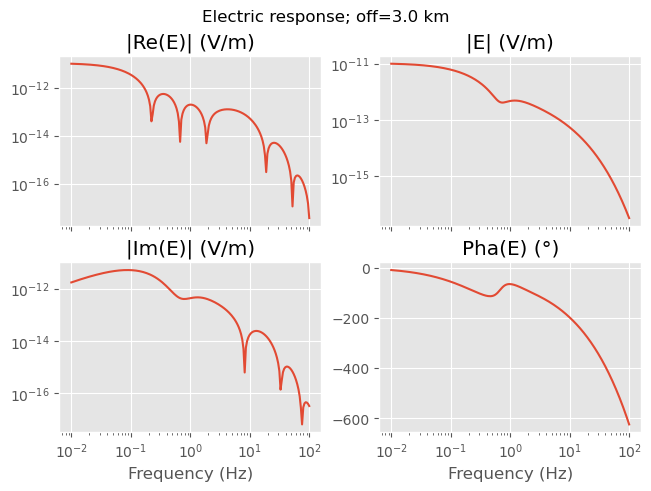

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, constrained_layout=True)

fig.suptitle(f'Electric response; off={offsets2/1e3} km')

ax1.set_title('|Re(E)| (V/m)')
ax1.loglog(frequency2, abs(efield2.real))

ax2.set_title('|E| (V/m)')
ax2.loglog(frequency2, efield2.amp())

ax3.set_title('|Im(E)| (V/m)')
ax3.loglog(frequency2, abs(efield2.imag))

ax4.set_title('Pha(E) (°)')
ax4.semilogx(frequency2, efield2.pha(deg=True))

for ax in [ax3, ax4]:
    ax.set_xlabel('Frequency (Hz)')

## Using input dicts

Makes it easy to compare different models

In [12]:
# x-directed bipole source: x0, x1, y0, y1, z0, z1
source = [-50, 50, 0, 0, -100, -100]

# Source frequency
frequency = 1

# Receiver offsets
offsets = np.linspace(500, 5000, 201)

# x-directed dipole receiver-array: x, y, z, azimuth, dip
receivers = [offsets, offsets*0, -200, 0, 0]

In [13]:
inp = {
    'src': source,
    'rec': receivers1,
    'depth': depth,
    'res': resistivities,
    'freqtime': frequency1,
    'htarg': {'pts_per_dec': -1},
    'verb': 1,
}

### Save/load input & CLI

See https://empymod.emsig.xyz/en/stable/manual/iocli.html

In [14]:
empymod.io.save_input('myrun.json', inp)

In [15]:
inp_loaded = empymod.io.load_input('myrun.json')

In [16]:
%%bash

empymod --help

usage: empymod [-h] [--report] [--version]
               [{bipole,dipole,loop,analytical}] [input] [output]

3D electromagnetic modeller for 1D VTI media.

positional arguments:
  {bipole,dipole,loop,analytical}
                        name of the modelling routine
  input                 input file name
  output                output file name; prints to STDOUT if not provided

options:
  -h, --help            show this help message and exit
  --report              show the empymod report and exit
  --version             show the empymod version and exit


In [17]:
!cat myrun.json

{
  "src": [-50, 50, 0, 0, -100, -100],
  "rec": [[500.0, 515.0, 530.0, 545.0, 560.0, 575.0, 590.0, 605.0, 620.0, 635.0, 650.0, 665.0, 680.0, 695.0, 710.0, 725.0, 740.0, 755.0, 770.0, 785.0, 800.0, 815.0, 830.0, 845.0, 860.0, 875.0, 890.0, 905.0, 920.0, 935.0, 950.0, 965.0, 980.0, 995.0, 1010.0, 1025.0, 1040.0, 1055.0, 1070.0, 1085.0, 1100.0, 1115.0, 1130.0, 1145.0, 1160.0, 1175.0, 1190.0, 1205.0, 1220.0, 1235.0, 1250.0, 1265.0, 1280.0, 1295.0, 1310.0, 1325.0, 1340.0, 1355.0, 1370.0, 1385.0, 1400.0, 1415.0, 1430.0, 1445.0, 1460.0, 1475.0, 1490.0, 1505.0, 1520.0, 1535.0, 1550.0, 1565.0, 1580.0, 1595.0, 1610.0, 1625.0, 1640.0, 1655.0, 1670.0, 1685.0, 1700.0, 1715.0, 1730.0, 1745.0, 1760.0, 1775.0, 1790.0, 1805.0, 1820.0, 1835.0, 1850.0, 1865.0, 1880.0, 1895.0, 1910.0, 1925.0, 1940.0, 1955.0, 1970.0, 1985.0, 2000.0, 2015.0, 2030.0, 2045.0, 2060.0, 2075.0, 2090.0, 2105.0, 2120.0, 2135.0, 2150.0, 2165.0, 2180.0, 2195.0, 2210.0, 2225.0, 2240.0, 2255.0, 2270.0, 2285.0, 2300.0, 2315.0, 2330.0,

In [18]:
%%bash

empymod bipole myrun.json output.json

In [19]:
empymod.io.load_data('output.json')

EMArray([[[ 1.68809093e-10-3.08303506e-10j],
          [ 1.48943975e-10-2.89388782e-10j],
          [ 1.31197343e-10-2.71648734e-10j],
          [ 1.15337476e-10-2.55007403e-10j],
          [ 1.01160966e-10-2.39394025e-10j],
          [ 8.84874180e-11-2.24743875e-10j],
          [ 7.71581902e-11-2.10996289e-10j],
          [ 6.70325915e-11-1.98094539e-10j],
          [ 5.79850664e-11-1.85985780e-10j],
          [ 4.99047462e-11-1.74620479e-10j],
          [ 4.26925678e-11-1.63952295e-10j],
          [ 3.62594055e-11-1.53937931e-10j],
          [ 3.05262493e-11-1.44536910e-10j],
          [ 2.54224833e-11-1.35711314e-10j],
          [ 2.08840292e-11-1.27425494e-10j],
          [ 1.68537655e-11-1.19646169e-10j],
          [ 1.32808057e-11-1.12342273e-10j],
          [ 1.01189209e-11-1.05484494e-10j],
          [ 7.32636747e-12-9.90453212e-11j],
          [ 4.86592722e-12-9.29991456e-11j],
          [ 2.70423205e-12-8.73220310e-11j],
          [ 8.10774358e-13-8.19912471e-11j],
          

## Interactive

In [20]:
import ipywidgets as widgets
from ipywidgets import interact

In [21]:
%matplotlib widget

In [22]:
off = np.linspace(500, 10000, 101)

In [23]:
resp = empymod.bipole(
    src=(0, 0, -250, 0, 0),  # x, y, z, azimuth, dip
    rec=(off, off*0, -300, 0, 0),
    depth=(0, -300, -2000, -2500),
    res=(2e14, 0.3, 1, 100, 1),
    freqtime=1,
    verb=1,
)

interactive(children=(FloatSlider(value=0.0, description='x', max=1000.0, step=10.0), Output()), _dom_classes=…

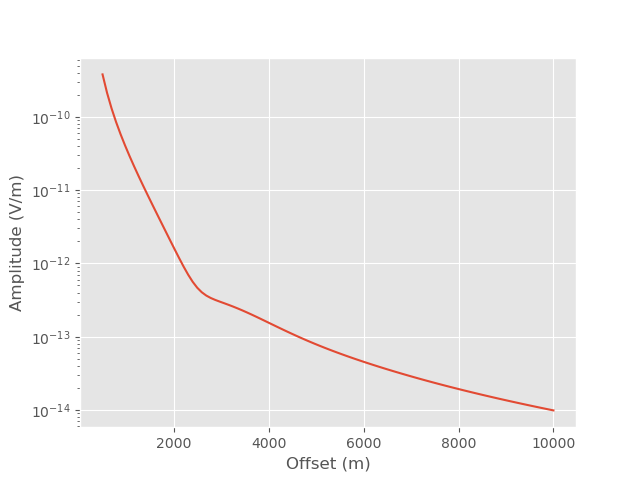

In [24]:

fig1, ax9 = plt.subplots()
ax9.set_ylabel('Amplitude (V/m)')
ax9.set_xlabel('Offset (m)')
ax9.set_yscale('log')
    
    
    
def f(x):
    resp = empymod.bipole(
        src=(0, 0, -250, 0, 0),  # x, y, z, azimuth, dip
        rec=(off, off*0+x, -300, 0, 0),
        depth=(0, -300, -2000, -2500),
        res=(2e14, 0.3, 1, 100, 1),
        freqtime=1,
        verb=1,
    )

    
    ax9.plot(off, resp.amp())
    
interact(f, x=widgets.FloatSlider(min=0, max=1000, step=10, value=0));

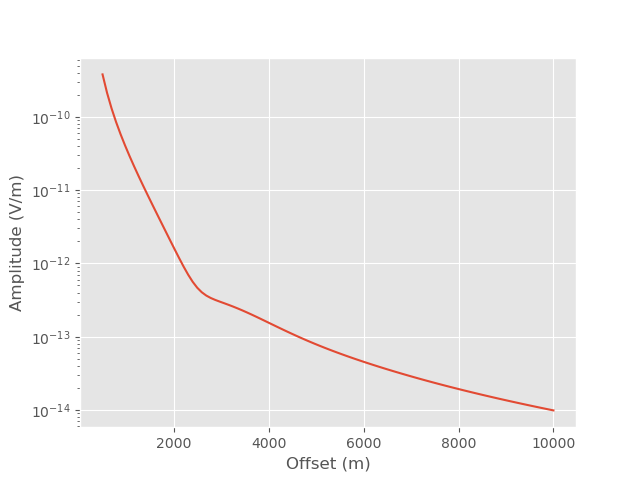

In [25]:
fig2, ax = plt.subplots()

ax.plot(off, resp.amp())
ax.set_ylabel('Amplitude (V/m)')
ax.set_xlabel('Offset (m)')
ax.set_yscale('log')

In [26]:
model = {
    'src': (0, 0, -250, 0, 0),  # x, y, z, azimuth, dip
    'rec': (off, off*0, -300, 0, 0),
    'depth': (0, -300, -1000, -1500),
    'freqtime': 1,
    'verb': 1,
}

In [27]:
resp_bg = empymod.bipole(res=(2e14, 0.3, 1, 1, 1), **model)
resp_tg = empymod.bipole(res=(2e14, 0.3, 1, 100, 1), **model)

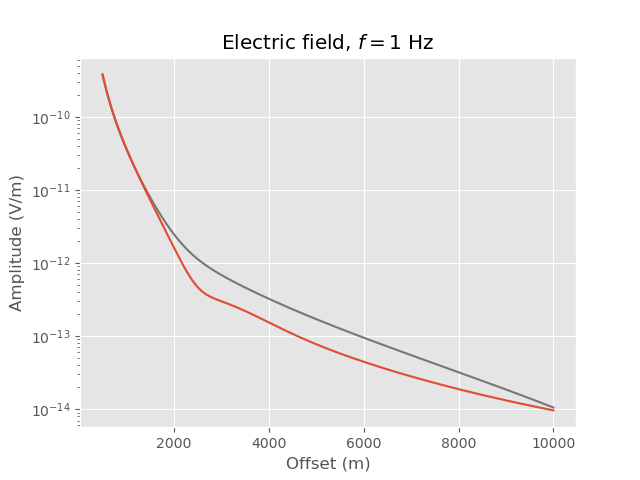

In [28]:
fig3, ax = plt.subplots()

ax.set_title(f"Electric field, $f=${model['freqtime']} Hz")
ax.plot(off, resp_tg.amp(), 'C3')
ax.plot(off, resp_bg.amp())
ax.set_ylabel('Amplitude (V/m)')
ax.set_xlabel('Offset (m)')
ax.set_yscale('log')

Text(0.5, 0, 'Offset (m)')

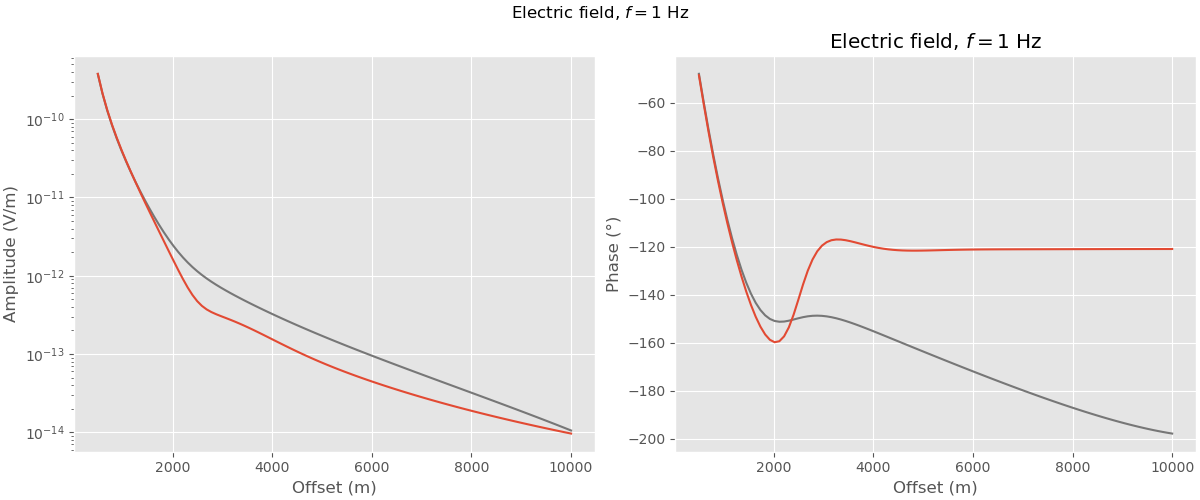

In [29]:
fig4, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, constrained_layout=True)

fig4.suptitle(f"Electric field, $f=${model['freqtime']} Hz")

ax1.plot(off, resp_tg.amp(), 'C3')
ax1.plot(off, resp_bg.amp())
ax1.set_ylabel('Amplitude (V/m)')
ax1.set_xlabel('Offset (m)')
ax1.set_yscale('log')

ax2.set_title(f"Electric field, $f=${model['freqtime']} Hz")
ax2.plot(off, resp_tg.pha(deg=True), 'C3')
ax2.plot(off, resp_bg.pha(deg=True))
ax2.set_ylabel('Phase (°)')
ax2.set_xlabel('Offset (m)')

## Depth sections

## Cross sections

# => Look at:

- TLE notebook
- WalkTEM
- Gallery
- Ziolkowski and Slob

## Finite length dipole vs point

Not looked at

- Time domain
- Loops
- Induced Polarization


### => Look at:

- Gallery: https://empymod.emsig.xyz/en/stable/gallery
- TLE-example: https://emsig.xyz/emlite/retro/notebooks/?path=TLE-Tutorial-2017.ipynb


## Keep in mind

empymod is very useful to quickly check ideas, concepts, and learn about the field.

However, keep in mind that it is only for layered models: You will almost always get an exagerated response in comparison with reality!

